In [42]:
import pandas as pd
from dataProcessor import process_metadata, clean_text, correct_misinterpreted_characters, pew_metadata_path, statista_metadata_path, llava_description_path
#  get the combined dataframe
combined_df = process_metadata(pew_metadata_path, statista_metadata_path, llava_description_path)
combined_df.shape

(29354, 5)

In [43]:
# Apply text cleaning and correction functions
combined_df['title'] = combined_df['title'].apply(clean_text).apply(correct_misinterpreted_characters)
combined_df['caption'] = combined_df['caption'].apply(clean_text).apply(correct_misinterpreted_characters)
combined_df['llava_description'] = combined_df['llava_description'].apply(clean_text).apply(correct_misinterpreted_characters)

In [44]:
combined_df

,id,title,caption,imgPath,llava_description
0,1,"Foreign-born population in the United States, ...",The foreign-born population residing in the U....,../dataset/pew_dataset/pew_imgs/1.png,The chart you've provided appears to be a line...
1,2,"English proficiency among U.S. immigrants, 198...","Since 1980, the share of immigrants who are pr...",../dataset/pew_dataset/pew_imgs/2.png,The chart you've provided shows the percentage...
2,3,"Languages spoken among U.S. immigrants, 2018","Among the nation’s immigrants, Spanish is by f...",../dataset/pew_dataset/pew_imgs/3.png,The chart presents the percentage of immigrant...
3,4,"Hispanic population in the U.S., 2000-2017",There were nearly 60 million Latinos in the Un...,../dataset/pew_dataset/pew_imgs/4.png,The chart you've provided appears to be a line...
4,5,Weekly broadcast audience for top 20 NPR-affil...,The top 20 NPR-affiliated public radio station...,../dataset/pew_dataset/pew_imgs/5.png,The chart you've provided is a line graph show...
...,...,...,...,...,...
29349,29350,Distribution of cyber stalking victims in 2013...,This statistic presents the distribution of cy...,../dataset/statista_dataset/statista_imgs/2786...,The chart you've provided appears to be a bar ...
29350,29351,Total number of dwellings in Great Britain fro...,This statistic displays the total number of dw...,../dataset/statista_dataset/statista_imgs/2786...,The chart you've provided appears to be a line...
29351,29352,Results in the European Parliament elections i...,This statistic shows the political parties and...,../dataset/statista_dataset/statista_imgs/2786...,The chart you've provided appears to be a bar ...
29352,29353,Average annual expenditure on curtains and dra...,This statistic shows the average annual expend...,../dataset/statista_dataset/statista_imgs/2786...,The chart you've provided appears to be a line...


In [45]:
from torch import Tensor
from transformers import AutoTokenizer
import pandas as pd

# Load the tokenizer and quantized model
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')

# Function to tokenize the title, caption, and LLaVA description, and get token lengths
def get_token_length(row):
    # Tokenize the title and caption separately
    title_tokens = tokenizer(row['title'], return_tensors="pt")
    caption_tokens = tokenizer(row['caption'], return_tensors="pt")
    llava_tokens = tokenizer(row['llava_description'], return_tensors="pt")
    
    # Combine title and caption into one string
    combined_text = row['title'] + " " + row['caption']
    
    # Tokenize the combined title and caption
    combined_tokens = tokenizer(combined_text, return_tensors="pt")
    
    # Get the token counts for each
    title_token_length = title_tokens['input_ids'].shape[1]
    caption_token_length = caption_tokens['input_ids'].shape[1]
    llava_token_length = llava_tokens['input_ids'].shape[1]
    combined_token_length = combined_tokens['input_ids'].shape[1]
    
    return title_token_length, caption_token_length, llava_token_length, combined_token_length


# Apply the function to each row and store the token lengths in separate columns
combined_df[['title_token_length', 'caption_token_length', 'llava_token_length', 'combined_token_length']] = combined_df.apply(lambda row: pd.Series(get_token_length(row)), axis=1)

# Select only the required columns to view the results
combined_df = combined_df[['id', 'title', 'caption', 'title_token_length', 'caption_token_length', 'llava_token_length', 'combined_token_length']]

# Sort the DataFrame by combined token length in descending order
combined_df = combined_df.sort_values(by='combined_token_length', ascending=False)

# View the DataFrame
combined_df

,id,title,caption,title_token_length,caption_token_length,llava_token_length,combined_token_length
11346,11347,Population of Poland from 1800 to 2020 ...,"Throughout the nineteenth century, what we kno...",68,990,467,1056
6540,6541,Population of France from 1700 to 2020 ...,"During the eighteenth century, it is estimated...",68,843,266,909
7487,7488,Population of Greece from 1821 to 2020 ...,"Prior to 1829, the area of modern day Greece w...",69,840,301,907
8186,8187,Number of assassinations and assassination att...,"Throughout U.S. history, there have been count...",23,882,235,903
4069,4070,Reported number of slaves owned by U.S. presid...,Of the first eighteen presidents of the United...,81,785,319,864
...,...,...,...,...,...,...,...
15730,15731,Do you yourself smoke marijuana?,This statistic shows the results of a 2015 sur...,8,27,653,33
10807,10808,Market forecast of global greentech industries...,This statistic gives a market forecast of the ...,17,17,523,32
20116,20117,Working population share in Luxembourg from 20...,"In 2020, approximately 70 percent of the popul...",11,22,289,31
16094,16095,Number of terrorist attacks in 2011 by region,The statistic shows the number of terrorist at...,10,22,469,30


In [46]:
# Calculating statistics for title and caption token lengths
max_title_token_length = combined_df['title_token_length'].max()
min_title_token_length = combined_df['title_token_length'].min()
mean_title_token_length = combined_df['title_token_length'].mean()
median_title_token_length = combined_df['title_token_length'].median()

max_caption_token_length = combined_df['caption_token_length'].max()
min_caption_token_length = combined_df['caption_token_length'].min()
mean_caption_token_length = combined_df['caption_token_length'].mean()
median_caption_token_length = combined_df['caption_token_length'].median()

max_llava_token_length = combined_df['llava_token_length'].max()
min_llava_token_length = combined_df['llava_token_length'].min()
mean_llava_token_length = combined_df['llava_token_length'].mean()
median_llava_token_length = combined_df['llava_token_length'].median()

# Create a dictionary to store the results
token_stats = {
    'Title': {
        'Max': max_title_token_length,
        'Min': min_title_token_length,
        'Mean': mean_title_token_length,
        'Median': median_title_token_length
    },
    'Caption': {
        'Max': max_caption_token_length,
        'Min': min_caption_token_length,
        'Mean': mean_caption_token_length,
        'Median': median_caption_token_length
    },
    'Llava_Caption': {
        'Max': max_llava_token_length,
        'Min': min_llava_token_length,
        'Mean': mean_llava_token_length,
        'Median': median_llava_token_length
}
}

# Convert to a DataFrame to display the results
token_stats_df = pd.DataFrame(token_stats)

# Display the DataFrame
print(token_stats_df)

             Title     Caption  Llava_Caption
Max     139.000000  990.000000    3639.000000
Min       3.000000   15.000000      54.000000
Mean     42.603427   88.935988     580.610683
Median   25.000000   57.000000     488.000000


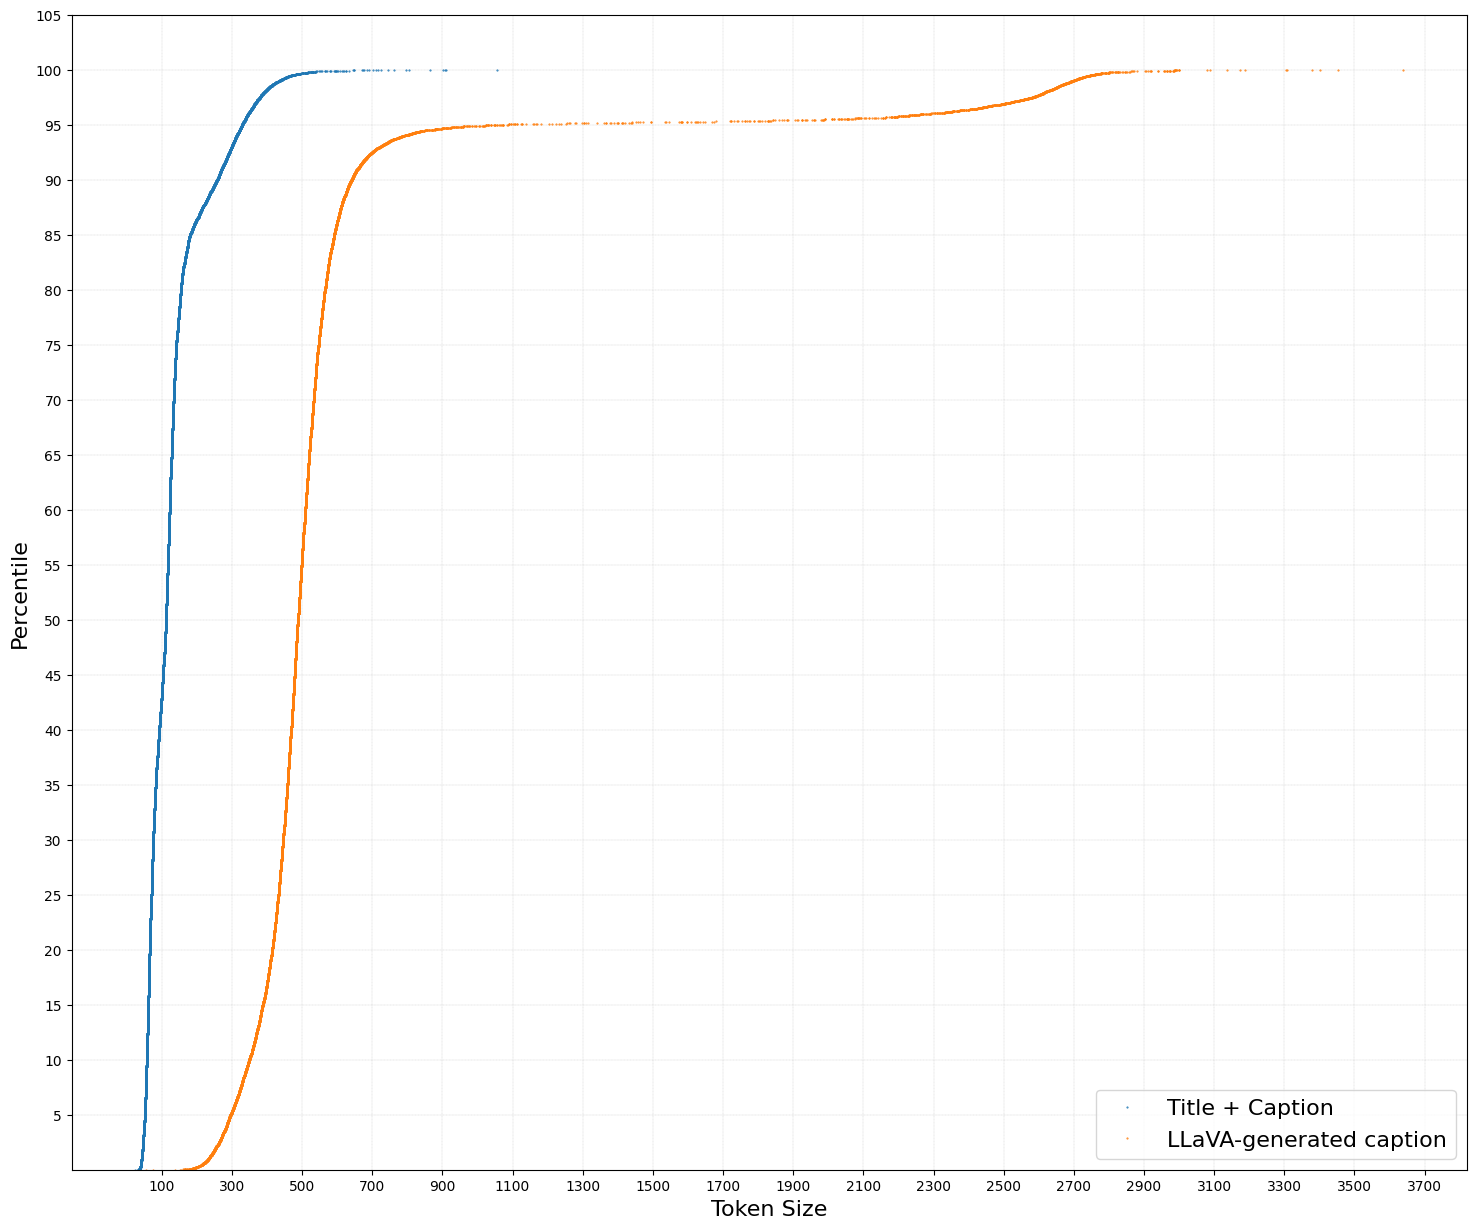

In [52]:
# Function to plot ECDF for two data columns in one figure with expanded token size and smaller markers
def plot_combined_ecdf(data1, data2, xlabel, ylabel, label1, label2, image_path=None):
    # Sort the data
    x1 = np.sort(data1)
    x2 = np.sort(data2)
    
    # Calculate ECDF (percentile in 0 to 100 range)
    y1 = (np.arange(1, len(x1)+1) / len(x1)) * 100
    y2 = (np.arange(1, len(x2)+1) / len(x2)) * 100
    
    # Create a combined plot
    plt.figure(figsize=(18, 15))
    
    # Plot for data1 (combined_token_length) with smaller markers
    plt.plot(x1, y1, marker='.', linestyle='none', label=label1, markersize=1)
    
    # Plot for data2 (llava_token_length) with smaller markers
    plt.plot(x2, y2, marker='.', linestyle='none', label=label2, markersize=1)
    
    # Label the axes
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
   # plt.title(title, fontsize=16)
    
    # Set Y-axis and expanded X-axis tick marks
    max_x = max(max(x1), max(x2))
    plt.yticks(np.arange(5, 106, 5))  # Y-axis from 10 to 100 in steps of 10
    plt.xticks(np.arange(100, max_x + 100, 200))  # Expand X-axis in steps of 500
    
    # Set Y-axis limits
    plt.ylim(0, 105)
    
    # Add grid lines and a legend
    plt.grid(True, which='both', linestyle='--', linewidth=0.2)
    plt.legend(fontsize=16)
    
    # Save the plot if a path is provided
    if image_path:
        plt.savefig(image_path)
    
    # Show the plot
    plt.show()

# Call the function to plot both ECDFs in one figure with smaller markers
plot_combined_ecdf(combined_df['combined_token_length'], combined_df['llava_token_length'], 
                   xlabel='Token Size', ylabel='Percentile', 
                   label1='Title + Caption', label2='LLaVA-generated caption')
